## Landmark Detection - Sunglasses filter. 
Using OpenCV's Haar cascades to detect faces in a live video stream from a webcam and applies a pre-trained deep learning model to detect key facial keypoints. Based on the positions of these keypoints, it overlays a pair of glasses on the eyes of the detected faces in real-time. 

In [ ]:
# Preprocessing
import numpy as np
import pandas as pd
import glob 

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import math

# Modelling
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPool2D, Dropout
from skimage.io import imshow, imread
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam
from os.path import join
from skimage.transform import resize
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Real time face detection
import cv2

### Preparing Data


In [ ]:
train_df = pd.read_csv('../training.csv')
test_df = pd.read_csv('../test.csv')

In [ ]:
train_df.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

In [ ]:
def has_nan(keypoints):
    """
    Checks if the input array contains any NaN values.

    Args:
    keypoints (numpy array): Input array to check for NaN values.

    Returns:
    bool: True if the input array contains NaN values, False otherwise.
    """
    for i in range(len(keypoints)):
        if math.isnan(keypoints[i]):
            return True
    return False

In [ ]:
# Define function to visualize image with keypoints
def visualize_points(img, points):
    """
    Visualizes an image with keypoints overlaid on it.
    
    Parameters:
    img (numpy.ndarray): The image to be visualized.
    points (numpy.ndarray): A 1-dimensional array of x-y coordinates of keypoints.
    
    Returns:
    None
    
    """
    fig, ax = plt.subplots(1)
    ax.set_aspect('equal')
    imshow(img)
    # Loop through each pair of x-y coordinates in the points array
    for i in range(0, len(points), 2):
        # Denormalize x-coordinate and y-coordinate by multiplying by 96 and adding 0.5
        x_renorm = (points[i] + 0.5) * 96
        y_renorm = (points[i+1] + 0.5) * 96
        # Create a circle object centered at the denormalized x-y coordinates with radius 1 pixel and red color
        circ = Circle((x_renorm, y_renorm), 1, color='r')
        ax.add_patch(circ)
    plt.show()


In [ ]:
def preprocess_data(df):
    """
    Preprocesses the input DataFrame for use in a facial keypoint detection model.

    Args:
    df (Pandas DataFrame): Input DataFrame containing facial keypoint data and image pixel data.

    Returns:
    Tuple of two numpy arrays: (train_imgs, train_points)
    train_imgs (numpy array): Array of training images.
    train_points (numpy array): Array of training keypoints.
    """
    train_imgs = []
    train_points = []
    # Loop over each row 
    for i in range(len(df)):
        points = df.iloc[i, :-1]
        if not has_nan(points):
            img_data = df.iloc[i, -1]
            # Convert the rows of the image column from pixel values separated by spaces to numpy arrays
            img_data = np.array(img_data.split(' ')).astype(int)
            # Reshape each row from one dimensional arrays to two dimensional arrays with dimensions (height, width) = (96, 96)
            img_data = np.reshape(img_data, (96, 96))
            # Normalize pixel values to a range between 0 and 1
            img_data = img_data / 255.0
            train_imgs.append(img_data)

            # Extract the keypoints data from the current row, convert it to integer type, and convert it to a numpy array
            keypoints = points.astype(int).values
            # Normalize the keypoints data by dividing by 96 and subtracting 0.5
            keypoints = keypoints / 96 - 0.5
            train_points.append(keypoints)
            
    train_imgs = np.array(train_imgs)
    train_points = np.array(train_points)

    return train_imgs, train_points


In [ ]:
imgs_train, points_train = preprocess_data(train_df)

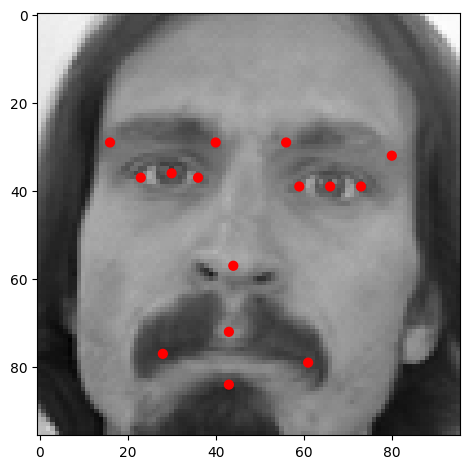

In [ ]:
# visualize the first sample of training data. 
visualize_points(imgs_train[0], points_train[0])

In [ ]:
def preprocess_test_data(test_df):
    test_imgs = []
    
    for i in range(len(test_df)):
        # Extract image data
        img_data = test_df.iloc[i, -1]
        img_data = np.array(img_data.split(' ')).astype(int)
        img_data = np.reshape(img_data, (96, 96))
        img_data = img_data / 255.0
        test_imgs.append(img_data)

    test_imgs = np.array(test_imgs)
    test_imgs = np.reshape(test_imgs, (test_imgs.shape[0], test_imgs.shape[1], test_imgs.shape[2], 1))
    
    return test_imgs


In [ ]:
imgs_test = preprocess_test_data(test_df)

### Preparing The Model.

* The model is a convolutional neural network (CNN)
* It consists of three convolutional layers followed by max pooling layers to extract features from the input images.
* The output of the convolutional layers is flattened and passed through two fully connected layers (Dense) to make predictions for the facial keypoints.
* The final layer has 30 units, corresponding to the x and y coordinates of 15 facial keypoints (e.g. left eye center, right eye center, nose tip, mouth corners, etc.). 
* The activation function used in the convolutional layers and the first fully connected layer is ReLU, which helps to introduce non-linearity into the model.

In [ ]:
def get_model():
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(96, 96, 1), activation="relu", padding="same"))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (5, 5), activation="relu", padding="same"))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5), activation="relu", padding="same"))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(512, activation="relu"))
    model.add(Dense(30))
    return model

In [ ]:
model = get_model()
model.compile(loss='mean_absolute_error', optimizer='adam', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 128)      0

In [ ]:
# checkpoint = ModelCheckpoint(filepath='weights/checkpoint-{epoch:02d}.hdf5')
# model.fit(imgs_train, points_train, epochs=100, batch_size=200, callbacks=[checkpoint])

In [ ]:
# # After training your model, save it to a file
# model.save('../model.h5')

In [ ]:
model.load_weights('../model.h5')

In [ ]:
# Testing the model
def test_model(model):    
    data_path = join('','*g')
    files = glob.glob(data_path)
    test_img = None   # Initialize test_img to None
   
    if test_img is not None:   # Check if test_img has a value
        test_img = np.array(test_img)
        test_img_input = np.reshape(test_img, (1,96,96,1))      # Model takes input of shape = [batch_size, height, width, no. of channels]
        prediction = model.predict(test_img_input)      # shape = [batch_size, values]
        visualize_points(test_img, prediction[0])
    
    # Test on first 5 samples of the test set
    for i in range(len(imgs_test)):
        test_img_input = np.reshape(imgs_test[i], (1,96,96,1))      # Model takes input of shape = [batch_size, height, width, no. of channels]
        prediction = model.predict(test_img_input)      # shape = [batch_size, values]
        visualize_points(imgs_test[i], prediction[0])
        if i == 5:
            break

1/1 [==============================] - 0s 296ms/step


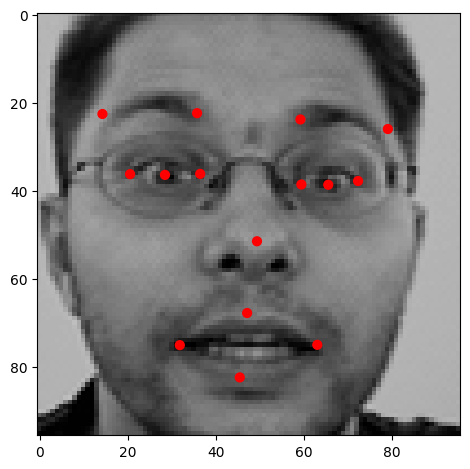

1/1 [==============================] - 0s 58ms/step


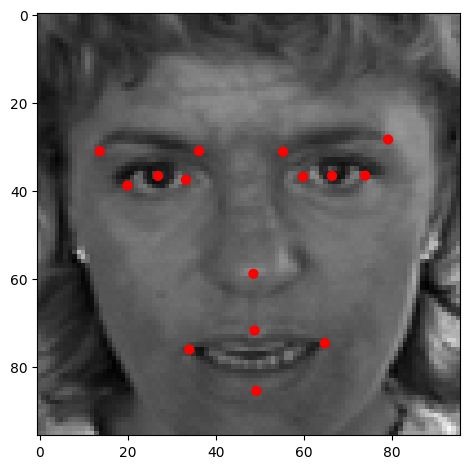

1/1 [==============================] - 0s 63ms/step


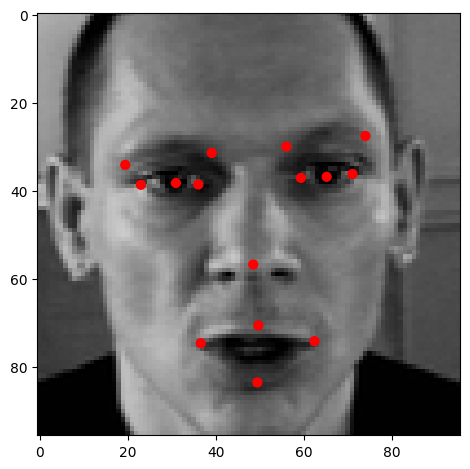

1/1 [==============================] - 0s 56ms/step


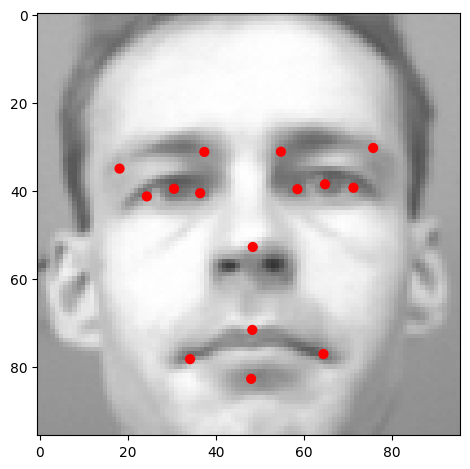

1/1 [==============================] - 0s 70ms/step


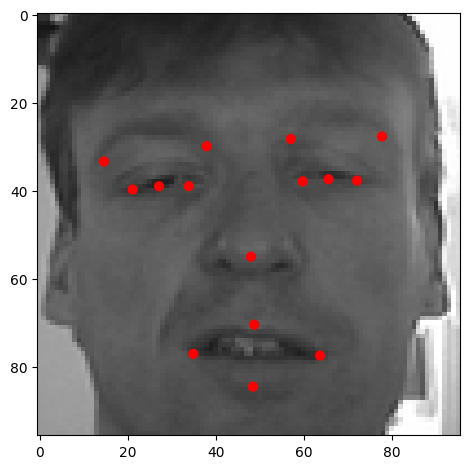

1/1 [==============================] - 0s 74ms/step


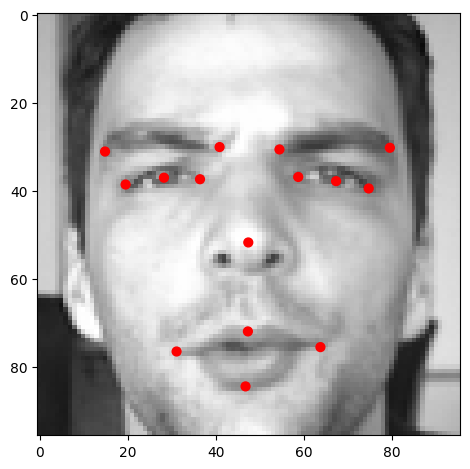

In [ ]:
test_model(model)

### Applying the predictions on real time face filter

In [ ]:
# frontal face haar cascade
face_cascade = cv2.CascadeClassifier('C:/Users/User/LandmarkDetection/cascades/haarcascade_frontalface_default.xml')

In [1]:
camera = cv2.VideoCapture(0)

NameError: name 'cv2' is not defined

In [25]:
# Keep running the code until the user interrupts it
while True:
    # Read an image from the camera
    grab_trueorfalse, img = camera.read()
    
    # Convert the RGB image to grayscale for preprocessing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detect the faces in the grayscale image
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    # For each detected face, do the following
    for (x,y,w,h) in faces:
        # Extract the region of interest (ROI) of the detected face
        roi_gray = gray[y:y+h, x:x+w]
        
        # Make a copy of the original image
        img_copy = np.copy(img) #for applying filter on the img
        img_copy_1 = np.copy(img) #for facial keypoints
        
        # Extract the color version of the ROI for later use
        roi_color = img_copy_1[y:y+h, x:x+w]

        # Get the width and height of the detected face
        width_original = roi_gray.shape[1]      
        height_original = roi_gray.shape[0]
        
        # Resize the ROI grayscale image to fit the model's input size and normalize the pixel values
        img_gray = cv2.resize(roi_gray, (96, 96))       
        img_gray = img_gray/255         
        
        # Reshape the grayscale image to fit the model's input shape
        img_model = np.reshape(img_gray, (1,96,96,1))
        
        # Predict the facial keypoints using the trained model
        keypoints = model.predict(img_model)[0]
        
        # Extract the x and y coordinates of the predicted keypoints
        x_coords = keypoints[0::2]     
        y_coords = keypoints[1::2]      
        
        # Denormalize the x and y coordinates to the original size of the face image
        x_coords_denormalized = (x_coords)*width_original       
        y_coords_denormalized = (y_coords+0.5)*height_original    
        
        # Extract the specific keypoints needed for scaling and positioning the glasses filter
        left_eye_coords = (int(x_coords_denormalized[3]), int(y_coords_denormalized[3]))
        right_eye_coords = (int(x_coords_denormalized[5]), int(y_coords_denormalized[5]))
        brow_coords = (int(x_coords_denormalized[6]), int(y_coords_denormalized[6]))
        
        # Convert the copy of the original image to a 4-channel image to support transparency overlay of the glasses filter
        img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGR2BGRA)
        
        # Calculate the width of the glasses filter based on the distance between the left and right eye keypoints
        glasses_width = left_eye_coords[0] - right_eye_coords[0]

       # Load the glasses filter image and resize it based on the calculated width and a fixed height
        glasses = cv2.imread('../glasses.png', -1)
        glasses = cv2.resize(glasses, (int(glasses_width*2), 150))
        gw,gh,gc = glasses.shape

        # Overlay the filter based on the alpha channel
        for i in range(0,gw):       
            for j in range(0,gh):
                if glasses[i,j][3] != 0:
                    img_copy[brow_coords[1]+i+y-50, left_eye_coords[0]+j+x-50] = glasses[i,j]
        img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGRA2BGR)       
        
        cv2.imshow('Output',img_copy)           # Output with the filter placed on the face
        cv2.imshow('Keypoints predicted',img_copy_1)        # Place keypoints on the webcam input     
    
    if cv2.waitKey(1) & 0xFF == ord("q"):   # q to quit
        break

1/1 [==============================] - 0s 69ms/step


: 